### Implementation in python

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import quad
from scipy import interpolate
from scipy.stats import norm
from scipy.optimize import brentq, least_squares
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import PchipInterpolator
import math as math
from sklearn.linear_model import LinearRegression

In [52]:
UNIT_BPS = 10000
UNIT_PCT= 100

## Market data  

### Swaption market volatilities

In [53]:
data_dict = {
    "labels": [-200, -150, -100, -50, -25, 0, 25, 50, 100, 150, 200],

    "1Y1Y": [91.57,62.03,44.13,31.224,26.182,22.5,20.96,21.4,24.34,27.488,30.297],
    "1Y2Y": [83.27,61.24,46.57,35.807,31.712,28.72,27.12,26.84,28.51,31.025,33.523],
    "1Y3Y": [73.92,56.87,44.77,35.745,32.317,29.78,28.29,27.8,28.77,30.725,32.833],
    "1Y5Y": [55.19,44.64,36.51,30.242,27.851,26.07,24.98,24.56,25.12,26.536,28.165],
    "1Y10Y": [41.18,35.04,30.207,26.619,25.351,24.47,23.98,23.82,24.25,25.204,26.355],

    "5Y1Y": [67.8,49.09,38.4,31.485,29.06,27.26,26.04,25.32,24.94,25.32,25.98],
    "5Y2Y": [57.88,46.41,39.033,33.653,31.531,29.83,28.56,27.65,26.71,26.54,26.76],
    "5Y3Y": [53.43,44.44,38.18,33.437,31.536,29.98,28.76,27.82,26.67,26.2,26.15],
    "5Y5Y": [41.99,36.524,32.326,29.005,27.677,26.6,25.73,25.02,24.06,23.57,23.4],
    "5Y10Y": [34.417,30.948,28.148,25.954,25.136,24.51,23.99,23.56,22.91,22.49,22.25],

    "10Y1Y": [55.16,44.32,37.368,32.259,30.21,28.54,27.31,26.45,25.61,25.52,25.78],
    "10Y2Y": [51.17,42.9,37.078,32.622,30.8,29.28,28.09,27.2,26.12,25.72,25.71],
    "10Y3Y": [48.22,41.43,36.4,32.439,30.796,29.4,28.27,27.38,26.18,25.58,25.37],
    "10Y5Y": [40.55,35.891,32.181,29.144,27.857,26.74,25.8,25.02,23.87,23.17,22.8],
    "10Y10Y": [33.601,30.509,27.978,25.926,25.086,24.37,23.76,23.24,22.44,21.9,21.56],
}

labels = data_dict["labels"]
keys = [k for k in data_dict.keys() if k != "labels"]
df_market_vol = pd.DataFrame({k: data_dict[k] for k in keys},index=labels)
df_market_vol

,1Y1Y,1Y2Y,1Y3Y,1Y5Y,1Y10Y,5Y1Y,5Y2Y,5Y3Y,5Y5Y,5Y10Y,10Y1Y,10Y2Y,10Y3Y,10Y5Y,10Y10Y
-200,91.570,83.270,73.920,55.190,41.180,67.800,57.880,53.430,41.990,34.417,55.160,51.170,48.220,40.550,33.601
-150,62.030,61.240,56.870,44.640,35.040,49.090,46.410,44.440,36.524,30.948,44.320,42.900,41.430,35.891,30.509
-100,44.130,46.570,44.770,36.510,30.207,38.400,39.033,38.180,32.326,28.148,37.368,37.078,36.400,32.181,27.978
-50,31.224,35.807,35.745,30.242,26.619,31.485,33.653,33.437,29.005,25.954,32.259,32.622,32.439,29.144,25.926
-25,26.182,31.712,32.317,27.851,25.351,29.060,31.531,31.536,27.677,25.136,30.210,30.800,30.796,27.857,25.086
0,22.500,28.720,29.780,26.070,24.470,27.260,29.830,29.980,26.600,24.510,28.540,29.280,29.400,26.740,24.370
25,20.960,27.120,28.290,24.980,23.980,26.040,28.560,28.760,25.730,23.990,27.310,28.090,28.270,25.800,23.760
50,21.400,26.840,27.800,24.560,23.820,25.320,27.650,27.820,25.020,23.560,26.450,27.200,27.380,25.020,23.240
100,24.340,28.510,28.770,25.120,24.250,24.940,26.710,26.670,24.060,22.910,25.610,26.120,26.180,23.870,22.440
150,27.488,31.025,30.725,26.536,25.204,25.320,26.540,26.200,23.570,22.490,25.520,25.720,25.580,23.170,21.900


### Spot rates

In [54]:
discount_factors = {
    0.5: 0.0025,
    1:   0.0030,
    2:   0.0033,
    3:   0.0034,
    4:   0.0035,
    5:   0.0036,
    7:   0.0040,
    10:  0.0045,
    15:  0.0050,
    20:  0.0053,
    30:  0.0055
}
discount_factors_interp = PchipInterpolator(np.array(list(discount_factors.keys())), np.array(list(discount_factors.values())))

def discount_factor_continuous(t):
    r_t = float(discount_factors_interp(t))
    return math.exp(-r_t * t)

def forward_rate_continuous(start_date, end_date):
    DF1 = discount_factor_continuous(start_date)
    DF2 = discount_factor_continuous(end_date)
    return -math.log(DF2 / DF1) / (end_date - start_date)

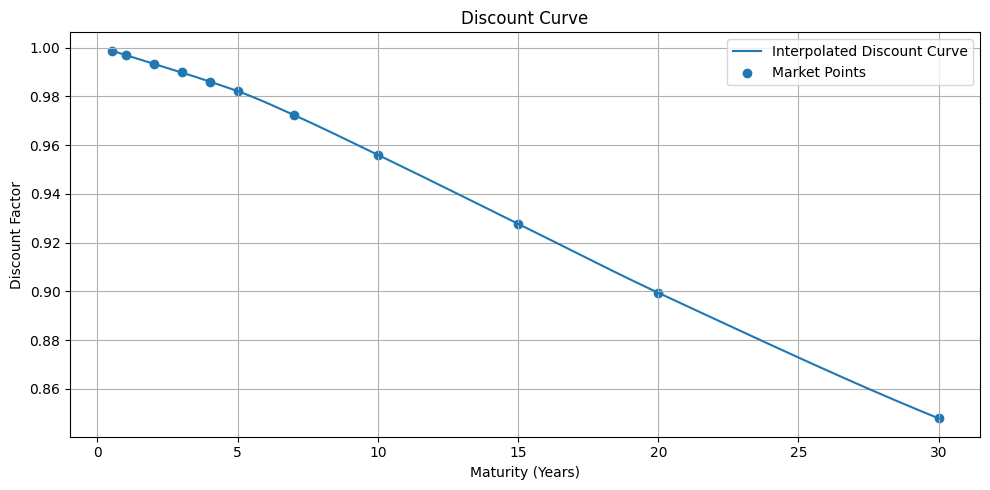

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator
import math

# Input discount rates (continuous compounding)
discount_factors = {
    0.5: 0.0025,
    1:   0.0030,
    2:   0.0033,
    3:   0.0034,
    4:   0.0035,
    5:   0.0036,
    7:   0.0040,
    10:  0.0045,
    15:  0.0050,
    20:  0.0053,
    30:  0.0055
}

# Build interpolator
tenors = np.array(list(discount_factors.keys()))
rates = np.array(list(discount_factors.values()))
discount_factors_interp = PchipInterpolator(tenors, rates)

# Discount factor function (continuous compounding)
def discount_factor_continuous(t):
    r_t = float(discount_factors_interp(t))
    return math.exp(-r_t * t)

# Generate curve
t_grid = np.linspace(min(tenors), max(tenors), 300)
df_curve = [discount_factor_continuous(t) for t in t_grid]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(t_grid, df_curve, label="Interpolated Discount Curve")
plt.scatter(tenors, [discount_factor_continuous(t) for t in tenors],
            marker='o', label="Market Points")

plt.xlabel("Maturity (Years)")
plt.ylabel("Discount Factor")
plt.title("Discount Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Estimating beta

In [56]:
spot_rate = {0.5: 0.0025, 1: 0.0030, 2: 0.0033, 3: 0.0034,
             4: 0.0035,5: 0.0036, 7: 0.0040, 10: 0.0045,
             15: 0.0050, 20: 0.0053, 30: 0.0055}
tenors = np.array(list(discount_factors.keys()))
rates = np.array(list(discount_factors.values()))
spot_rate_interp = PchipInterpolator(tenors,rates)

def forward_rate(start_date, end_date):
    DF1 = math.exp(-float(spot_rate_interp(start_date)) * start_date)
    DF2 = math.exp(-float(spot_rate_interp(end_date)) * end_date)
    return -math.log(DF2 / DF1) / (end_date - start_date)

vol_atm = (df_market_vol.T)[0].values/100
texp =  (df_market_vol.T).index
t_exp = [(int(x.split('Y')[0]), int(x.split('Y')[1])) for x in texp]
forwar_rate = [forward_rate(t, t+expiry )for (t,expiry) in t_exp]
Y = np.log(vol_atm)
X = np.log(forwar_rate).reshape(-1, 1) 
reg = LinearRegression().fit(X, Y)
beta = reg.coef_[0] + 1 
print(f'beta = {beta}')

beta = 1.0469809969618098


## Full Parametrisation

In [57]:
def get_sabr_volatility(F, K, T, alpha, rho, nu, beta=0.9):
    if abs(F - K) < 1e-12: 
        FK_beta = F ** (1 - beta)
        term1 = ((1 - beta) ** 2 / 24) * (alpha ** 2) / (F ** (2 - 2 * beta))
        term2 = 0.25 * rho * beta * nu * alpha / (F ** (1 - beta))
        term3 = ((2 - 3 * rho ** 2) / 24) * nu ** 2
        return alpha / FK_beta * (1 + (term1 + term2 + term3) * T)
    
    FK_beta = (F * K) ** ((1 - beta) / 2)
    logFK = np.log(F / K)
    z = (nu / alpha) * FK_beta * logFK
    x_z = np.log((np.sqrt(1 - 2 * rho * z + z ** 2) + z - rho) / (1 - rho))
    
    term1 = ((1 - beta) ** 2 / 24) * (alpha ** 2) / (FK_beta ** 2)
    term2 = 0.25 * rho * beta * nu * alpha / FK_beta
    term3 = ((2 - 3 * rho ** 2) / 24) * nu ** 2
    
    numerator = alpha * (1 + (term1 + term2 + term3) * T) * z
    denominator = FK_beta * (1 + ((1 - beta) ** 2 / 24) * logFK ** 2 +
                             ((1 - beta) ** 4 / 1920) * logFK ** 4) * x_z
    sigma = numerator / denominator
    return sigma
    
def calibrate_sabr(expiry, tenor, forward_swap_rate, vol_market,moneyness_change):
    key = f"{tenor}Y{expiry}Y"
    vol_market = df_market_vol[key].values / UNIT_PCT 
    moneyness_change = df_market_vol.index.values / UNIT_BPS
    def residuals(params):
        alpha, rho, nu = params
        error = 0
        for i, vol in enumerate(vol_market):
            K = forward_swap_rate + moneyness_change[i] 
            vol_sabr = get_sabr_volatility(forward_swap_rate,  K, expiry, alpha, rho, nu)
            error = error + (vol_sabr - vol)**2
        return error    
    initial_guess = [0.02, 0.0, 0.5]
    bounds = ([0.0001, -0.999, 0.0001], [1.0, 0.999, 2.0])
    res = least_squares(residuals, initial_guess, bounds=bounds, max_nfev=6000)
    return  res.x

### Test
expiry = 1
tenor = 5
forwar_swap_rate = 0.0352554715328091
key = f"{tenor}Y{expiry}Y"
vol_market = df_market_vol[key].values / UNIT_PCT 
moneyness_change = df_market_vol.index.values / UNIT_BPS
sabr_calibration_params = calibrate_sabr(expiry, tenor, forwar_swap_rate, vol_market,moneyness_change)
print(f'alpha =  {sabr_calibration_params[0]} rho =  {sabr_calibration_params[1]} vol_of_vol =  {sabr_calibration_params[2]}')    

alpha =  0.18546181769429998 rho =  -0.5645382840151069 vol_of_vol =  1.304292476581463


## Second Parameterization Estimating and v

In [58]:
def solve_alpha_from_atm_vol(beta, rho, nu, sigma_ATM, f, T):
    A = (1 - beta**2) / (24 * f**(2*(1-beta)))
    B = (rho * beta * nu) / (4 * f**(1-beta))
    C = 1
    D = -sigma_ATM * f**(1-beta)

    roots = np.roots([A, B, C, D])

    pos = [r.real for r in roots if abs(r.imag) < 1e-10 and r.real > 0]
    return min(pos)


def calibrate_sabr_partial(expiry, tenor, forward_swap_rate, vol_market,moneyness_change,vol_atm):
    key = f"{tenor}Y{expiry}Y"
    vol_market = df_market_vol[key].values / UNIT_PCT 
    moneyness_change = df_market_vol.index.values / UNIT_BPS
    sigma_atm = vol_market[moneyness_change == 0][0]

    def residuals(params):
        rho, nu = params
        error = 0
        alpha = solve_alpha_from_atm_vol(beta,rho,nu,vol_atm,forward_swap_rate,expiry)
        for i, vol in enumerate(vol_market):
            K = forward_swap_rate + moneyness_change[i] 
            vol_sabr = get_sabr_volatility(forward_swap_rate,  K, expiry, alpha, rho, nu)
            error = error + (vol_sabr - vol)**2
        return error    
    initial_guess = [0.0, 1]
    bounds = ([-0.999, 0.0001], [0.999, 2.0])
    res = least_squares(residuals, initial_guess, bounds=bounds, max_nfev=6000)
    alpha = solve_alpha_from_atm_vol(beta,res.x[0],res.x[1],vol_atm,forward_swap_rate,expiry)
    print(alpha)
    return  (alpha,res.x)

##Test
expiry = 1
tenor = 5
forwar_swap_rate = 0.0352554715328091
key = f"{tenor}Y{expiry}Y"
vol_market = df_market_vol[key].values / UNIT_PCT 
moneyness_change = df_market_vol.index.values / UNIT_BPS
vol_atm = vol_market[moneyness_change == 0][0]
sabr_calibration_params = calibrate_sabr2(expiry, tenor, forwar_swap_rate, vol_market,moneyness_change,vol_atm)
rho = sabr_calibration_params[0]
vol_of_vol = sabr_calibration_params[1]
alpha = solve_alpha_from_atm_vol(beta,rho,vol_of_vol,vol_atm,forwar_swap_rate,expiry)
print(f'alpha =  {alpha} rho =  {rho} vol_of_vol =  {vol_of_vol}')
#alpha =  0.3832636143287463 rho =  -0.975572275300387 vol_of_vol =  1.9999991761376847


alpha =  0.3832636143287463 rho =  -0.975572275300387 vol_of_vol =  1.9999991761376847
